In [1]:
import skmob
from skmob.models import gravity
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
np.random.seed(0)

In [4]:
station_df = pd.read_csv('./data/station-coor.csv', index_col=0)
station_df.head(2)

,abbr,lat,lon
0,12TH,37.803768,-122.271450
1,16TH,37.765062,-122.419694


In [20]:
data_X_all = gpd.read_file('./data/data_X_all.shp').iloc[:48, :]
tess = data_X_all[['TotPop', 'nearest st', 'geometry']]
print(tess.shape)
tess.head(2)

(48, 3)


,TotPop,nearest st,geometry
0,11084.0,12TH,"POLYGON ((-122.28374 37.79480, -122.28343 37.7..."
1,142973.0,16TH,"POLYGON ((-122.43467 37.75611, -122.43564 37.7..."


In [30]:
OD = np.load('./data/3d_daily.npy').sum(axis=2)[:48, :48]
OD_df = pd.DataFrame(OD, index=tess['nearest st'].values, columns=tess['nearest st'].values)

In [31]:
OD_df.shape

(48, 48)

In [38]:
ODa = OD_df.stack().reset_index().set_axis(['origin', 'destination', 'flow'], axis=1)
ODa = ODa.sort_values(by=['origin', 'destination']).reset_index(drop=True)
fdf = skmob.FlowDataFrame(ODa, origin='origin', destination='destination', flow='flow', tessellation=tess,
                          tile_id='nearest st')

/opt/anaconda3/envs/bda_traff/lib/python3.8/site-packages/skmob/core/flowdataframe.py:145: UserWarning: The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).
  warn("The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).")


In [40]:
tot_outflows = fdf[fdf['origin']!=fdf['destination']].groupby(by='origin', axis=0)[['flow']].sum()
tess = tess.merge(tot_outflows, left_on='nearest st', right_on='origin').rename(columns={'flow': 'tot_outflow'})
tess.head()

,TotPop,nearest st,geometry,tot_outflow
0,11084.0,12TH,"POLYGON ((-122.28374 37.79480, -122.28343 37.7...",3825906.0
1,142973.0,16TH,"POLYGON ((-122.43467 37.75611, -122.43564 37.7...",3876465.0
2,36177.0,19TH,"MULTIPOLYGON (((-122.26276 37.81013, -122.2630...",3829293.0
3,104191.0,24TH,"POLYGON ((-122.41661 37.73725, -122.41595 37.7...",3707008.0
4,70630.0,ANTC,"POLYGON ((-121.78097 37.96618, -121.78142 37.9...",831803.0


In [60]:
fdf_train = fdf[:1612]
fdf_train.shape

(1612, 3)

In [61]:
count = [1 if fdf_train.loc[i, 'origin']==fdf_train.loc[i, 'destination'] else 0 for i in fdf_train.index]
sum(count)

33

In [62]:
ODb = ODa.pivot(index='origin', columns='destination', values='flow')
ODb.head()

destination,12TH,16TH,19TH,24TH,ANTC,ASHB,BALB,BAYF,CAST,CIVC,...,SANL,SBRN,SFIA,SHAY,SSAN,UCTY,WARM,WCRK,WDUB,WOAK
origin,,,,,,,,,,,,,,,,,,,,,
12TH,19393.0,96890.0,19207.0,80981.0,47854.0,70423.0,44547.0,86293.0,31071.0,216975.0,...,98460.0,22829.0,40191.0,45239.0,24088.0,61400.0,50588.0,88315.0,35887.0,28286.0
16TH,107540.0,19689.0,140540.0,65858.0,32145.0,71125.0,160873.0,44761.0,23917.0,181807.0,...,50959.0,45502.0,55348.0,23336.0,40723.0,30306.0,27817.0,40822.0,28619.0,121698.0
19TH,18662.0,132113.0,18229.0,93940.0,36350.0,73479.0,36500.0,63004.0,23223.0,255870.0,...,69282.0,19545.0,32528.0,39738.0,19363.0,57150.0,59220.0,89026.0,34957.0,19593.0
24TH,92368.0,63201.0,99287.0,22551.0,17140.0,36486.0,144357.0,24849.0,9884.0,282787.0,...,30621.0,41628.0,45624.0,13820.0,31815.0,11738.0,10014.0,21050.0,11892.0,70277.0
ANTC,49157.0,25107.0,37423.0,14708.0,14938.0,2988.0,11067.0,2353.0,401.0,67176.0,...,4697.0,6408.0,31119.0,1809.0,5769.0,3088.0,4066.0,27023.0,542.0,5340.0


In [63]:
OD_ = np.array(ODb)  # shape: [num_cities, num_cities]
OD_ = OD_.reshape(-1, 1)
scalar_OD = preprocessing.MinMaxScaler().fit(OD_)

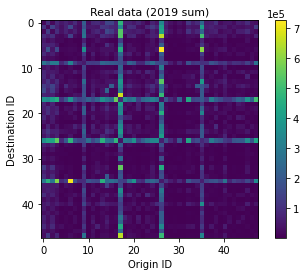

In [64]:
plt.imshow(ODb)
plt.xlabel('Origin ID')
plt.ylabel('Destination ID')
plt.title('Real data (2019 sum)', fontsize=11)
plt.colorbar().formatter.set_powerlimits((0, 0))

# Gravity model

## Singly constrained

### Power law deterrence function

In [65]:
singly_fitted1 = gravity.Gravity(gravity_type='singly constrained')
print(singly_fitted1)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="singly constrained")


In [66]:
singly_fitted1.fit(fdf_train, relevance_column='TotPop')
print(singly_fitted1)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-0.35444794697787074], origin_exp=1.0, destination_exp=-0.11491288317627688, gravity_type="singly constrained")


In [67]:
fdf_fit1 = singly_fitted1.generate(tess, tile_id_column='nearest st', tot_outflows_column='tot_outflow',
                                   relevance_column='TotPop', out_format='flows')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 19201.39it/s]
/opt/anaconda3/envs/bda_traff/lib/python3.8/site-packages/skmob/models/gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)
/opt/anaconda3/envs/bda_traff/lib/python3.8/site-packages/skmob/core/flowdataframe.py:145: UserWarning: The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).
  warn("The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).")


In [68]:
fdf_fit1

,origin,destination,flow
0,12TH,16TH,70948.755974
1,12TH,19TH,169891.235186
2,12TH,24TH,76827.566234
3,12TH,ANTC,49973.710874
4,12TH,ASHB,116713.115327
...,...,...,...
2251,NCON,UCTY,9770.532884
2252,NCON,WARM,9774.066094
2253,NCON,WCRK,15751.731216
2254,NCON,WDUB,11227.446777


In [71]:
OD_fit1 = pd.DataFrame(fdf_fit1[['origin', 'destination', 'flow']])
OD_rec1 = OD_fit1.pivot(index='origin', columns='destination', values='flow').fillna(0)
print(OD_rec1.shape)
OD_rec1.head()

(48, 48)


destination,12TH,16TH,19TH,24TH,ANTC,ASHB,BALB,BAYF,CAST,CIVC,...,SANL,SBRN,SFIA,SHAY,SSAN,UCTY,WARM,WCRK,WDUB,WOAK
origin,,,,,,,,,,,,,,,,,,,,,
12TH,0.000000,70948.755974,169891.235186,76827.566234,49973.710874,116713.115327,67101.890589,69477.695708,68000.457413,73649.504658,...,76512.061354,68633.317551,85739.302602,60758.296195,67092.896732,54800.803025,52347.941796,69697.568707,58851.135475,160239.230938
16TH,103402.149754,0.000000,86715.265251,121160.613996,49575.914682,83552.330284,114745.162212,63836.784397,63414.626307,147310.865364,...,67024.640529,85688.727600,102240.304250,59321.209103,90003.387040,54516.071122,53471.568485,63150.204779,57309.131107,105402.410370
19TH,192599.860197,67452.145399,0.000000,72391.798588,50129.620385,125179.388720,64088.058785,68884.360443,67766.018481,70085.009111,...,76068.073217,65953.636924,82612.828432,60159.657824,64311.138630,54264.928444,51816.462189,71215.066590,58672.014251,135837.341650
24TH,102746.267190,111179.741389,85399.111108,0.000000,47590.903746,80208.342110,108055.046774,63974.474750,62972.137793,100743.454651,...,67329.706338,89268.310118,105692.786672,58905.518102,94038.014680,53858.537791,52417.434622,61028.543207,56226.987890,104086.339901
ANTC,20367.726441,13863.947534,18022.306681,14503.603835,0.000000,17504.524084,13835.466843,16410.485799,17699.193032,14181.274051,...,16610.593712,15039.479087,19177.800067,16479.263643,14400.893061,15729.193906,16136.120835,20991.500744,18528.341376,18962.389269


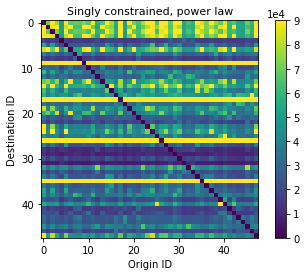

In [72]:
plt.imshow(OD_rec1, vmin=0, vmax=9e4)
plt.xlabel('Origin ID')
plt.ylabel('Destination ID')
plt.title('Singly constrained, power law', fontsize=11)
plt.colorbar().formatter.set_powerlimits((0, 0))

In [76]:
# OD_rec1.stack().reset_index().iloc[1612:, :].to_csv('./res/dg and g/g_pred.csv')